# Meili Documentation
https://valhalla.readthedocs.io/en/latest/meili/implementation_details/

In [1]:
### communicate with os
import os

### Data Analysis Packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

### Data Visialization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import date2num
from matplotlib import gridspec
%matplotlib inline
import contextily as cx

### Maps Visualization
import folium

## Geo Packages
from shapely import wkt, wkb
from shapely.geometry import Point, LineString, Polygon
import geopandas as gpd
from geopy.distance import distance
import polyline

### progressbar for loops
from progressbar import progressbar
from tqdm import tqdm

## Handle Requests
import requests
import json

## Handle Warnings
import warnings

## Writing to DB
import psycopg2 as pg

### Matplotlib Visualization Parameters
params = {'figure.figsize':  (8, 5),
          'legend.fontsize': 14,
          'axes.labelsize':  14,
          'axes.titlesize':  16,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,}
sns.set_style('whitegrid')
plt.rcParams.update(params)

# Read Trips File

In [2]:
file_names=os.listdir('waypoints/')

In [3]:
%time

df=pd.read_csv('waypoints/'+file_names[0])

gdf=gpd.GeoDataFrame(data=df.drop(columns='geometry'),
                     geometry=df['geometry'].apply(lambda x: wkb.loads(x, hex=True)),
                     crs='EPSG:4326')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


In [214]:
gdf.head()

,trip_id,count,geometry
0,bed0276ff8f6bebd6dcf9d1d3d274cd2,55,"LINESTRING (8.54790 49.70380, 8.54537 49.71328..."
1,f92a0d0cd9d7f8f57df5c326fb4bf059,386,"LINESTRING (8.55350 49.97660, 8.55395 49.97668..."
2,181de36a5376d5dcfb795eac18c1fe5d,34,"LINESTRING (8.48350 50.07930, 8.48506 50.09734..."
3,614bd8563ba86a3a7cc93cf605f4e6f1,2434,"LINESTRING (6.82222 49.78425, 6.82367 49.78410..."
4,7e91b7fa95e790bd3c8195a94bcafb7f,12,"LINESTRING (8.28530 49.78670, 8.29978 49.79847..."


In [215]:
gdf.shape

(100000, 3)

# Visualize Trips

In [4]:
def plot_trip_folium(sample_trip_id):

    temp_gdf=gdf[gdf['trip_id']==sample_trip_id]
    points=temp_gdf['geometry'].iloc[0].xy
    map_= folium.Map(location=(points[1][-1],points[0][-1]), zoom_start=13)

    for lon,lat in zip(points[0],points[1]):
        folium.CircleMarker([lat,lon],radius=5,weight=2,color='blue',
                            fill=True,fill_color='blue',fill_opacity=1).add_to(map_)
    return map_

In [5]:
plot_trip_folium('f92a0d0cd9d7f8f57df5c326fb4bf059')

# MapMatching

In [75]:
def plot_trip_MapMatched_folium(sample_trip_id):

    df_temp=matched[matched['trip_id']==sample_trip_id].copy()
    
    df_temp['matched']= df_temp['lon_mm'].notna()

    temp_gdf=gdf[gdf['trip_id']==sample_trip_id]
    points=temp_gdf['geometry'].iloc[0].xy
    map_= folium.Map(location=(points[1][-1],points[0][-1]), zoom_start=13)

    for lon,lat in zip(points[0],points[1]):
        folium.CircleMarker([lat,lon],radius=5,weight=2,color='blue',
                            fill=True,fill_color='blue',fill_opacity=1).add_to(map_)

    for point in df_temp[df_temp['matched']][['lat_mm','lon_mm']].values:
        folium.CircleMarker(list(point),radius=5,weight=2,color='red',
                            fill=True,fill_color='red',fill_opacity=1).add_to(map_)

    for LineS in metadata[metadata['trip_id']==sample_trip_id].geometry:
        folium.GeoJson(LineS).add_to(map_)
    
    return map_

In [77]:
steps_list=[]
matched_list=[]
metadata_list=[]

not_matched_point_dict= {'matchings_index': np.nan,'waypoint_index': np.nan,'alternatives_count': np.nan,
                          'distance': np.nan,'name': np.nan,'location': np.nan}

# for _,row in tqdm(gdf.iterrows()):
for i in tqdm(range(len(gdf))):
    
    row=gdf.iloc[i]
    
    # Get TripID and Points of the current trip
    current_trip_id= row['trip_id']
    points=row['geometry'].xy

    # Turning our points sequence into a JSON
    # We need that because that is a Meili's request requirement
    trip_temp= pd.DataFrame({'lon':points[0],'lat':points[1],'time':list(range(len(points[0])))})
    meili_coordinates = trip_temp[['lon','lat']].to_json(orient='records')

    # Providing needed data for the body of Meili's request
    meili_head = '{"shape":'
    # Those are parameters that you can change according to the Meili's documentation
    meili_tail = ""","search_radius": 50, "breakage_distance":5000, "mode":"auto", "shape_match":"map_snap", "costing":"auto","format":"osrm"}"""

    # Combining all the string into a single request
    meili_request_body = meili_head + meili_coordinates + meili_tail
    
    
    # The URL of our local Valhalla server
    # "trace_route" means that we're sending a request to Meili
    url = "http://localhost:8002/trace_route"

    # Providing headers to the request
    headers = {'Content-type': 'application/json'}

    # We need to send our JSON as a string
    data = str(meili_request_body)

    # Sending a request
    r = requests.post(url, data=data, headers=headers)
    
    # If request is successfull and we get a valid response:
    if r.status_code == 200:

        response_text = json.loads(r.text)
        
        ######### get map matching metadata like duration, distance, ..
        # contains the encoded polyline geometry for visualization
        metadata_mm= pd.json_normalize(response_text['matchings']).drop(columns='legs')
        metadata_mm['code']=response_text['code']
        metadata_mm['trip_id']=current_trip_id
        metadata_list.append(metadata_mm)
        
        ######### get steps for navigations (turns): Location + instructions
        steps_mm= pd.json_normalize(response_text['matchings'][0]['legs'][0]['steps']).reset_index().rename(columns={'index':'sequence'})
        steps_mm['trip_id']=current_trip_id
        steps_list.append(steps_mm)
        
        ######### get map matched points
        # first the response text has to be cleaned. Points which could not be matched are returned as None
        # these have to be replaced with a dict which contains np.nan
        resp=pd.json_normalize(response_text)['tracepoints'][0]
        matched_points = pd.DataFrame([not_matched_point_dict if x==None else x for x in resp])
        # After taking care of None and creating a df of points, the tripIDs are merged to be able to know 
        # which point is which and to be able to compare before-after mapmatching for a certain point
        matched_points['lon_mm']=matched_points['location'].apply(lambda x: x if x!=x else x[0])
        matched_points['lat_mm']=matched_points['location'].apply(lambda x: x if x!=x else x[1])
        matched_points['trip_id']=current_trip_id
        matched_points['time']=trip_temp['time'].reset_index(drop=True)
        # remove [matchings_index, waypoint_index, alternatives_count]
        matched_points=matched_points[['trip_id','name', 'distance', 'lon_mm', 'lat_mm','time']]
        matched_list.append(matched_points)


100%|████████████████████████████████████████████████████████| 100000/100000 [1:25:05<00:00, 19.59it/s]


In [94]:
print('trips count:\n')
print('All:     ', len(gdf))
print('matched: ', len(matched_list))
print('error:   ', len(gdf)-len(matched_list))

trips count:

All:      100000
matched:  77523
error:    22477


# Results

In [78]:
steps= pd.concat(steps_list)
matched= pd.concat(matched_list)
metadata= pd.concat(metadata_list)

# create lon lat columns for steps
steps['lon']=steps['maneuver.location'].apply(lambda x: x[0])
steps['lat']=steps['maneuver.location'].apply(lambda x: x[1])

# Convert encoded polyline to LineString
metadata['geometry']=metadata['geometry'].apply(lambda x: LineString(polyline.decode(x, precision=6, geojson=True)))
steps['geometry']=steps['geometry'].apply(lambda x: LineString(polyline.decode(x, precision=6, geojson=True)))

In [95]:
matched.drop(columns='name').head()

,trip_id,distance,lon_mm,lat_mm,time
0,bed0276ff8f6bebd6dcf9d1d3d274cd2,0.829,8.547889,49.703799,0
1,bed0276ff8f6bebd6dcf9d1d3d274cd2,1.067,8.545383,49.713286,1
2,bed0276ff8f6bebd6dcf9d1d3d274cd2,2.225,8.543085,49.722521,2
3,bed0276ff8f6bebd6dcf9d1d3d274cd2,0.855,8.543133,49.732780,3
4,bed0276ff8f6bebd6dcf9d1d3d274cd2,2.387,8.543417,49.742809,4


In [96]:
metadata.drop(columns=['weight_name','weight','confidence','code']).head()

,duration,distance,geometry,trip_id
0,140.004,4372.163,"LINESTRING (8.547889 49.703799, 8.545511 49.71...",bed0276ff8f6bebd6dcf9d1d3d274cd2
1,341.799,9967.781,"LINESTRING (8.543998 49.763313, 8.544005 49.76...",bed0276ff8f6bebd6dcf9d1d3d274cd2
2,163.555,4706.582,"LINESTRING (8.600016 49.866035, 8.600112 49.86...",bed0276ff8f6bebd6dcf9d1d3d274cd2
3,348.720,10168.354,"LINESTRING (8.613317 49.929364, 8.613343 49.92...",bed0276ff8f6bebd6dcf9d1d3d274cd2
4,652.231,9598.560,"LINESTRING (8.596768 50.037869, 8.597408 50.03...",bed0276ff8f6bebd6dcf9d1d3d274cd2


In [97]:
metadata[['geometry']].head()

,geometry
0,"LINESTRING (8.547889 49.703799, 8.545511 49.71..."
1,"LINESTRING (8.543998 49.763313, 8.544005 49.76..."
2,"LINESTRING (8.600016 49.866035, 8.600112 49.86..."
3,"LINESTRING (8.613317 49.929364, 8.613343 49.92..."
4,"LINESTRING (8.596768 50.037869, 8.597408 50.03..."


In [70]:
matched['trip_id'].unique()

array(['bed0276ff8f6bebd6dcf9d1d3d274cd2',
       'f92a0d0cd9d7f8f57df5c326fb4bf059',
       '181de36a5376d5dcfb795eac18c1fe5d'], dtype=object)

In [76]:
plot_trip_MapMatched_folium('181de36a5376d5dcfb795eac18c1fe5d')

In [ ]:
map_= folium.Map(location=(points[1][-1],points[0][-1]), zoom_start=13)
folium.GeoJson(LineS).add_to(map_)
map_

# Share of matched points in each trip

In [104]:
mathced_share= [len(df.dropna())/len(df) for df in matched_list]
trip_IDs=[df['trip_id'].iloc[0] for df in matched_list]

In [109]:
mathced_share_df=pd.DataFrame({'trip_id':trip_IDs,'mm_share':mathced_share})

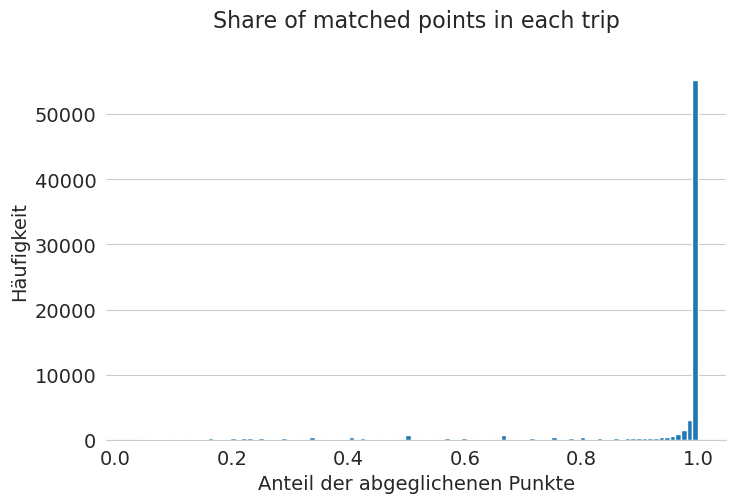

In [219]:
# Histogram of share of matched points
plt.figure(dpi=100)
mathced_share_df['mm_share'].plot(kind='hist', bins=100)
plt.title('Share of matched points in each trip\n')
plt.grid(axis='x', which='major')
plt.xlabel('Anteil der abgeglichenen Punkte')
plt.ylabel('Häufigkeit')
sns.despine(left=True)
plt.show()

In [117]:
mathced_share_df[mathced_share_df['mm_share']==1].shape

(48829, 2)

# Find trips which have 100% matched points and just one Linestring in Metadata
These can be used to compare distances before and after map-matching


In [124]:
mask_100_percent=metadata['trip_id'].isin(mathced_share_df[mathced_share_df['mm_share']==1]['trip_id'].values)

In [138]:
LineStringCountForTripsWith100PercentMatchedPoints=\
metadata[mask_100_percent]['trip_id'].value_counts().to_frame()

In [139]:
trips100percentMM1LineS=\
LineStringCountForTripsWith100PercentMatchedPoints\
[LineStringCountForTripsWith100PercentMatchedPoints['trip_id']==1]

In [154]:
metadata_1mm_1LineS= metadata[metadata['trip_id'].isin(trips100percentMM1LineS.index)]

In [165]:
gdf_1mm_1LineS=gdf[gdf['trip_id'].isin(trips100percentMM1LineS.index)].copy()
gdf_1mm_1LineS['distance_beforeMM']=gdf_1mm_1LineS.to_crs('EPSG:5243').length

In [196]:
gdf_1mm_1LineS= gdf_1mm_1LineS[(gdf_1mm_1LineS['count']>25)]

In [197]:
distance_beforeAfterMM_1mm_1LineS=pd.merge(left=metadata_1mm_1LineS,
                                           right=gdf_1mm_1LineS[['trip_id','distance_beforeMM']],
                                           how='inner',
                                           on='trip_id')

distance_beforeAfterMM_1mm_1LineS['absoluteError']=\
distance_beforeAfterMM_1mm_1LineS['distance_beforeMM']-distance_beforeAfterMM_1mm_1LineS['distance']

distance_beforeAfterMM_1mm_1LineS['relativeError']=\
distance_beforeAfterMM_1mm_1LineS['absoluteError']/distance_beforeAfterMM_1mm_1LineS['distance_beforeMM']

In [199]:
distance_beforeAfterMM_1mm_1LineS.to_csv('distance_beforeAfterMM_1mm_1LineS.csv', index=False)

In [200]:
distance_beforeAfterMM_1mm_1LineS[['absoluteError','relativeError']].describe()

,absoluteError,relativeError
count,19573.000000,19573.000000
mean,-284.849602,-0.015731
std,436.495268,0.052121
min,-8710.645916,-3.258057
25%,-371.631605,-0.017424
50%,-131.652673,-0.006093
75%,-34.653260,-0.001729
max,512.958412,0.805108


In [202]:
distance_beforeAfterMM_1mm_1LineS[['distance_beforeMM','distance']].describe()

,distance_beforeMM,distance
count,19573.000000,19573.000000
mean,34408.145623,34692.995225
std,40375.003708,40462.716832
min,101.592704,34.180000
25%,7958.851321,8140.826000
50%,19252.037173,19634.467000
75%,42104.569449,42496.156000
max,200083.973213,204508.094000


In [213]:
plot_trip_MapMatched_folium('69683adb733d7528cbb476f86b3ee4dd')

# Visualize several trips

In [221]:
distance_beforeAfterMM_1mm_1LineS.trip_id.sample(5)

14226    2e427834cdaca95808ebac925810ca14
15263    ee4301b31c5f4355259cf500ce3e2962
4584     2f4dd39f354c0a269f240782708da9d9
5880     abdd88afdd879834b0c2b632802bfb0f
15758    e5420c2a4bec6ddbec40a8f246feb59e
Name: trip_id, dtype: object

In [222]:
plot_trip_MapMatched_folium('2e427834cdaca95808ebac925810ca14')

In [223]:
plot_trip_MapMatched_folium('ee4301b31c5f4355259cf500ce3e2962')

In [224]:
plot_trip_MapMatched_folium('2f4dd39f354c0a269f240782708da9d9')

In [225]:
plot_trip_MapMatched_folium('abdd88afdd879834b0c2b632802bfb0f')

In [226]:
plot_trip_MapMatched_folium('e5420c2a4bec6ddbec40a8f246feb59e')

# Save Results

In [100]:
name=file_names[0]

matched.drop(columns='name').to_csv(name.replace('.csv','_MapMatchedPoints.csv'), index=False)
metadata.drop(columns=['weight_name','weight','confidence','code'])\
.to_csv(name.replace('.csv','_MapMatchedMetadata.csv'), index=False)